# setup

In [1]:
run_test=True
run_test=False
epochs=(1,1)
epochs=(20,500)
cutdate='2024-04-30'
itr=5
metrics_cnt=6
import torch,sys

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  mydrive='/content/drive/MyDrive/volrt/'
  source_path=mydrive+"git/Crossformer"
  tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
  batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*64
  import os,sys
  if not os.path.exists(source_path):
    %cd $mydrive/git
    !git clone https://github.com/jerronl/Crossformer.git
    %cd $source_path
  else:
    %cd $source_path
    !git reset --hard HEAD
    !git pull origin master
  !pip install einops #scikit-learn
  sys.path.append( source_path)
else:
  tables = [ 'volvA.csv', 'volvG.csv', ]
  mydrive= 'E:/mydoc/git/trade/analyics/'
  batch_size=32
%cd $mydrive


E:\mydoc\git\trade\analyics


d:\ProgramData\miniconda3\envs\e1\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:


import argparse
import torch

from cross_exp.exp_crossformer import Exp_crossformer
from utils.tools import string_split


parser = argparse.ArgumentParser(description="CrossFormer")

parser.add_argument("--data", type=str, default="vols", help="data")
parser.add_argument(
    "--root_path", type=str, default=mydrive, help="root path of the data file"
)
parser.add_argument("--data_path", type=list, default=tables, help="data file")
parser.add_argument(
    "--data_split",
    type=str,
    default="0.7,0.1,0.2",
    help="train/val/test split, can be ratio or number",
)
parser.add_argument(
    "--checkpoints",
    type=str,
    default="./checkpoints/",
    help="location to store model checkpoints",
)

parser.add_argument("--in_len", type=int, default=20, help="input MTS length (T)")
parser.add_argument("--out_len", type=int, default=1, help="output MTS length (\tau)")
parser.add_argument("--seg_len", type=int, default=5, help="segment length (L_seg)")
parser.add_argument(
    "--win_size", type=int, default=2, help="window size for segment merge"
)
parser.add_argument(
    "--factor",
    type=int,
    default=10,
    help="num of routers in Cross-Dimension Stage of TSA (c)",
)

parser.add_argument(
    "--d_model", type=int, default=256, help="dimension of hidden states (d_model)"
)
parser.add_argument(
    "--d_ff", type=int, default=512, help="dimension of MLP in transformer"
)
parser.add_argument("--n_heads", type=int, default=4, help="num of heads")
parser.add_argument("--e_layers", type=int, default=3, help="num of encoder layers (N)")
parser.add_argument("--dropout", type=float, default=0.2, help="dropout")

parser.add_argument(
    "--baseline",
    action="store_true",
    help="whether to use mean of past series as baseline for prediction",
    default=False,
)

parser.add_argument(
    "--num_workers", type=int, default=0, help="data loader num workers"
)
parser.add_argument(
    "--batch_size", type=int, default=32, help="batch size of train input data"
)
parser.add_argument("--train_epochs", type=int, default=20, help="train epochs")
parser.add_argument("--patience", type=int, default=3, help="early stopping patience")
parser.add_argument(
    "--learning_rate", type=float, default=1e-4, help="optimizer initial learning rate"
)
parser.add_argument("--lradj", type=str, default="type1", help="adjust learning rate")
parser.add_argument("--itr", type=int, default=itr, help="experiments times")

parser.add_argument(
    "--save_pred",
    action="store_true",
    help="whether to save the predicted future MTS",
    default=False,
)

parser.add_argument("--use_gpu", type=bool, default=True, help="use gpu")
parser.add_argument("--resume", type=bool, default=True, help="resume")
parser.add_argument("--query", type=str, default=None, help="resume")
# parser.add_argument("--use_gpu", type=bool, default=False, help="use gpu")
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument(
    "--use_multi_gpu", action="store_true", help="use multiple gpus", default=False
)
parser.add_argument(
    "--devices", type=str, default="0,1,2,3", help="device ids of multile gpus"
)

args = parser.parse_args(args=[])

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(" ", "")
    device_ids = args.devices.split(",")
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)


def update_args(itr):
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        for k,v in data_info.items():
            args.__setattr__(k,v)
    if isinstance(args.data_split, str) :
        args.data_split = string_split(args.data_split)

    print("Args in experiment:")
    print(args)
    setting = "Crossformer_il{}_ol{}_sl{}_win{}_fa{}_dm{}_nh{}_el{}_itr{}".format(
        args.in_len,
        args.out_len,
        args.seg_len,
        args.win_size,
        args.factor,
        args.d_model,
        args.n_heads,
        args.e_layers,
        itr,
    )
    return setting
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt



def regplot(cols, figsize=(16, 16)):
    global metrics
    cnt = len(dep_var) - dep_var.count("_")
    figs = min(cnt, cols)
    _, axes = plt.subplots(math.ceil(cnt / figs), figs, figsize=figsize)
    j = 0

    for i, name in enumerate(dep_var):
        if name != "_":
            axs = axes.flat[j] if figs > 1 else axes
            j = j + 1
            left, right = 999, -999
            for ii in range(len(tables)):
                preds, trues, _ = results[ii]
                sns.regplot(
                    ax=axs,
                    x=trues[:, i],
                    y=preds[:, i],
                    scatter_kws={"color": f"C{ii}", "alpha": 0.3},
                    line_kws={"color": f"C{ii}", "alpha": 0.3},
                    label=tables[ii],
                )
                mask = ~np.isnan(trues[:, i])
                if not dep_var[i][:3] in ["dtm", "pmc"]:
                    left = min(left, max(np.min(trues[:, i][mask]), -5))
                    right = max(right, min(np.max(trues[:, i][mask]), 5))
                else:
                    left = min(left, np.min(trues[:, i][mask]))
                    right = max(right, np.max(trues[:, i][mask]))
            axs.set_title(name)
            axs.set_xlim(left=left, right=right)
            axs.legend()
    metric = []
    for ii in range(len(tables)):
        _, _, m = results[ii]
        metric.append(m)

    metrics = np.append(
        metrics, np.array(metric).reshape([1, len(metric), len(m)]), axis=0
    )

    plt.show()


def plot_metric(*args, **kwargs):
    a, b, c = metrics.shape
    _, axs = plt.subplots(
        nrows=math.ceil(c / 2),
        ncols=2,
    )
    for i in range(c):
        ax = (
            axs[i // 2, i % 2] if c > 1 else axs
        )  # Handle the case when c=1 to avoid indexing errors
        for j in range(a):
            ax.plot(
                metrics[j, :, i], label=labels[0][j], *args, **kwargs
            )  # Plot each series in the i-th plot
        ax.set_title(labels[2][i])
        ax.legend()  # Show legend in each subplot

        # Set custom x-axis labels
        ax.set_xticks(range(b))  # Set x-tick positions for all 'b' points
        ax.set_xticklabels(labels[1])  # Set x-tick labels

    plt.tight_layout()
    plt.show()


# train

In [3]:
if not run_test:
    from cross_exp.exp_crossformer import Exp_crossformer
    from data.data_loader import DatasetMTS
    data_parser = {
        "vols": {
            "patience":epochs[0],
            "train_epochs":epochs[1],
            'learning_rate':0.01,
            'data_split':[0.7,0.15,0.15],
            'batch_size':batch_size*2//5,
            'e_layers':5,
            'd_model':512,
            'lradj':'type2',
            "checkpoints":"./checkpoints/",
        },
        }
    for i in range(itr):
        for ii in range(5):
            # setting record of experiments
            setting = update_args(ii)
            DatasetMTS.clear()

            exp = Exp_crossformer(args)  # set experiments
            print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
            exp.train(setting, "vols")

            print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
            preds, trues,_ = exp.test(setting, 'vols', True, data_path=[tables[-1]], inverse=True)
            print(preds.shape, trues.shape)

            exp.train(setting, "prcs")
            preds, trues,_ = exp.test(setting, 'prcs', True, data_path=[tables[-1]], inverse=True)
            print(preds.shape, trues.shape)
        data_parser["vols"]["learning_rate"]/=3.

In [4]:
if not run_test:
    from google.colab import runtime
    runtime.unassign()

# test

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query=None, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0vols/crossformer.pkl 
volvA.csv 0        #2022-12-27 09:33:55#
7453     #2023-08-30 15:59:28#
9050     #2023-10-26 10:47:49#
10692    #2023-12-21 12:58:47#
Name: date, dtype: object
test 1597
 mae:0.403, mse:0.766, rmse:0.853, mape:1025605.984, mspe:7649119205763520.000, accr:-1.0 

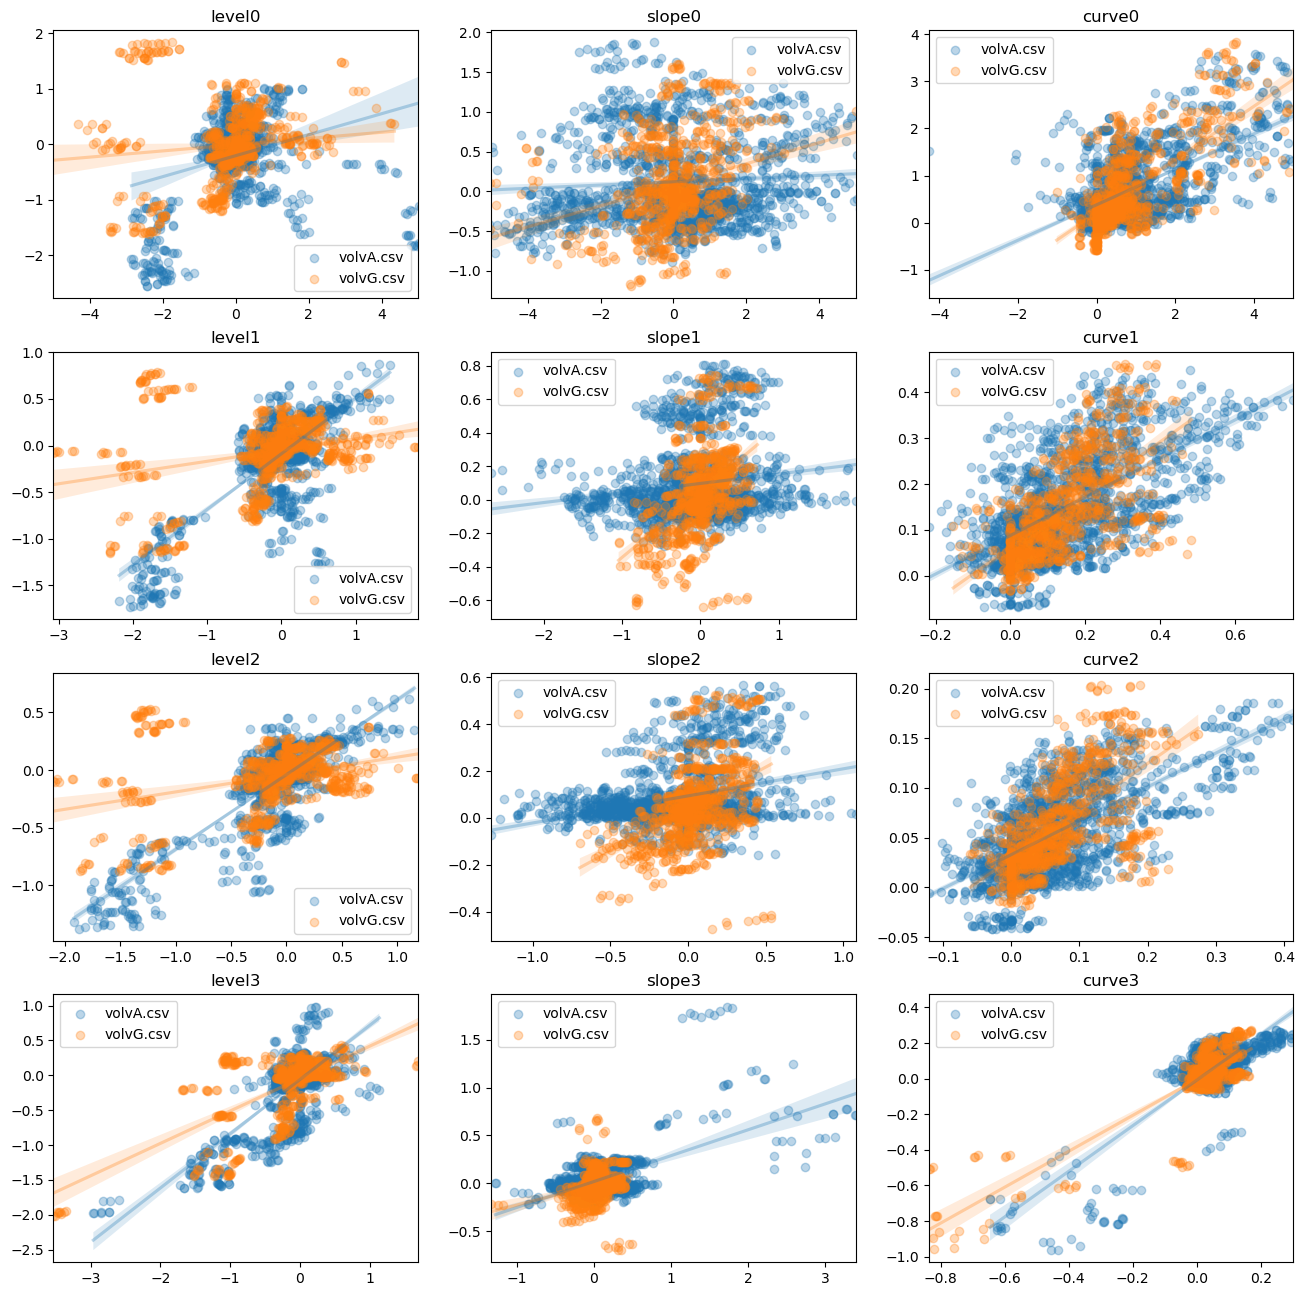

[[[ 4.02718065e-01  7.65732689e-01  8.53120084e-01  1.02560598e+06
    7.64911921e+15 -1.00000000e+00]
  [ 3.13594022e-01  4.26613357e-01  5.97506586e-01  9.02891522e+05
    3.79374021e+15 -1.00000000e+00]]]


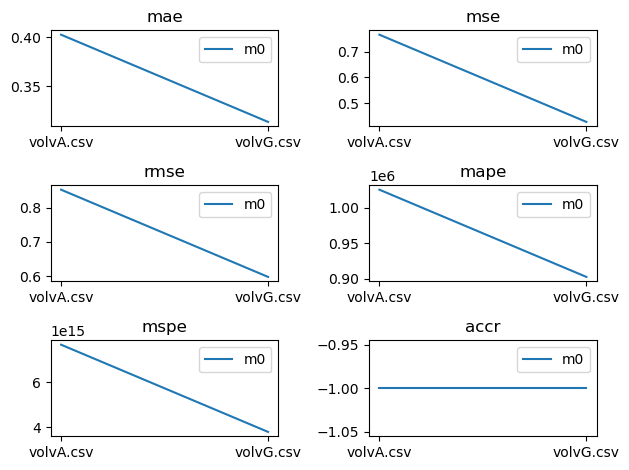

In [5]:
from data.data_loader import DatasetMTS
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
    },
    }
dep_var=['level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
labels=[[f'm{i}' for i in range(itr)],tables,["mae", "mse", "rmse", "mape", "mspe", "accr"]]
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(3)

print(metrics)
plot_metric()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query=None, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0vols/crossformer.pkl 
volvA.csv 0        #2022-12-27 09:33:55#
7453     #2023-08-30 15:59:28#
9050     #2023-10-26 10:47:49#
10692    #2023-12-21 12:58:47#
Name: date, dtype: object
test 1597
 mae:0.403, mse:0.766, rmse:0.853, mape:1025605.984, mspe:7649119205763520.000, accr:-1.0 

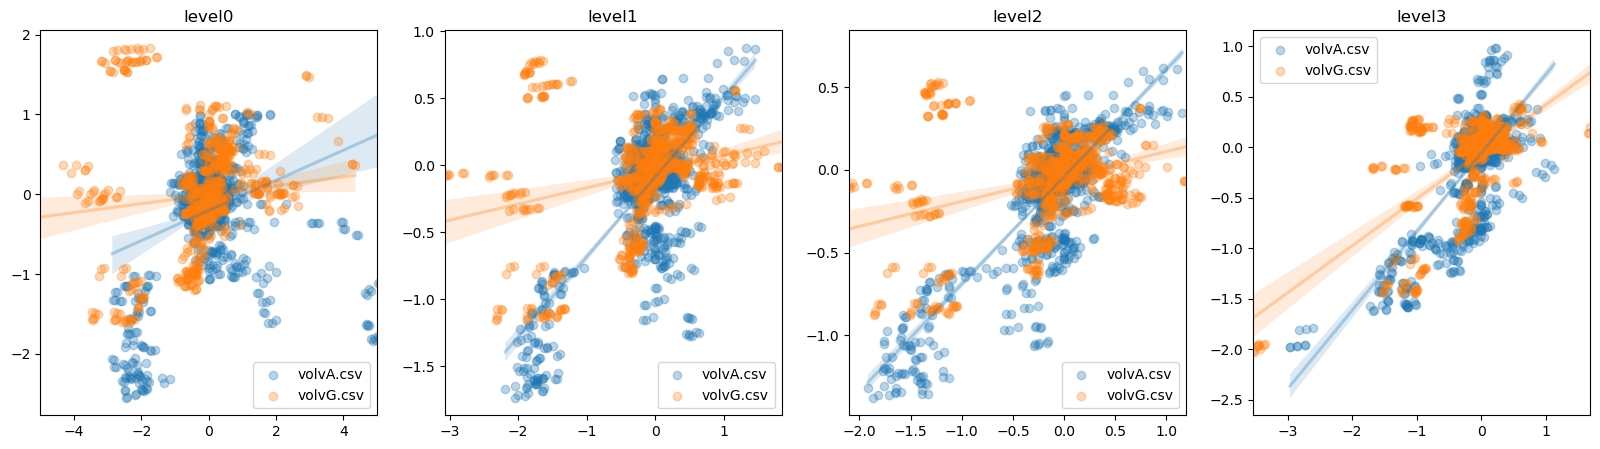

In [6]:
dep_var=['level0', '_', '_', 'level1', '_', '_', 'level2', '_', '_', 'level3', '_', '_']
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(4,(20,5))

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query=None, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0prcs/crossformer.pkl 
volvA.csv 2        #2022-12-27 15:58:18#
7826     #2023-09-13 15:59:29#
9448     #2023-11-07 15:57:12#
11134    #2024-01-12 15:58:36#
Name: date, dtype: object
test 595
 mae:1.332, mse:8.801, rmse:2.813, mape:4598.543, mspe:50264280031.508, accr:0.058823529411

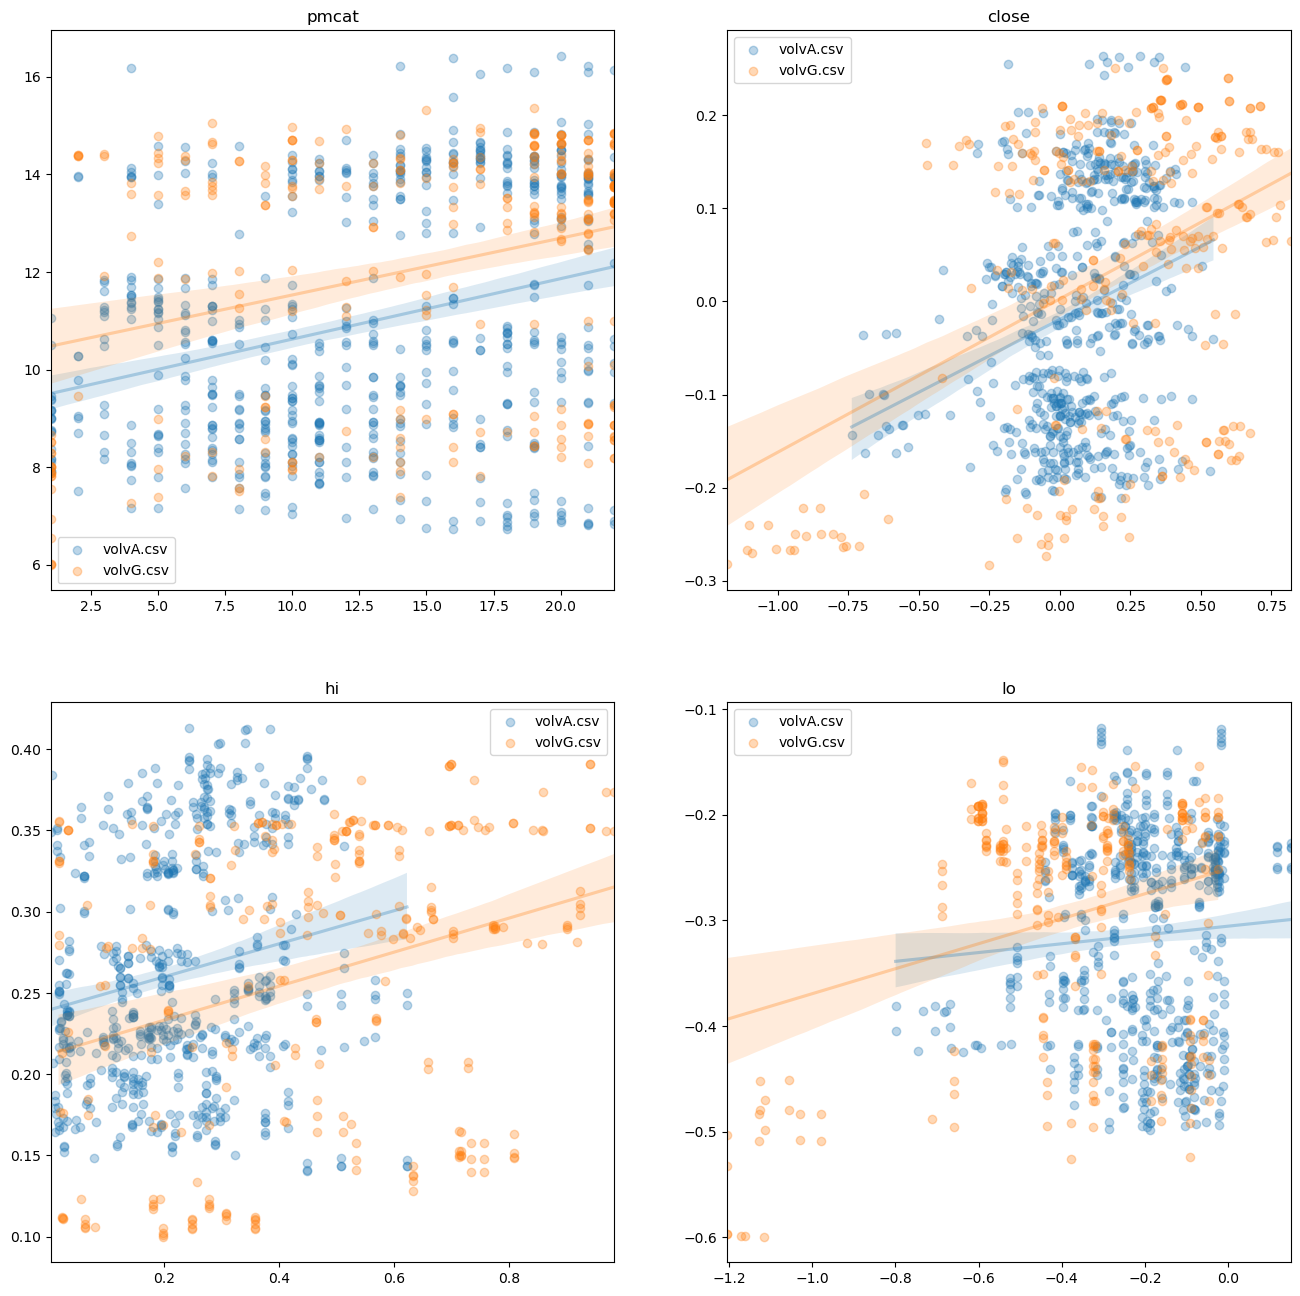

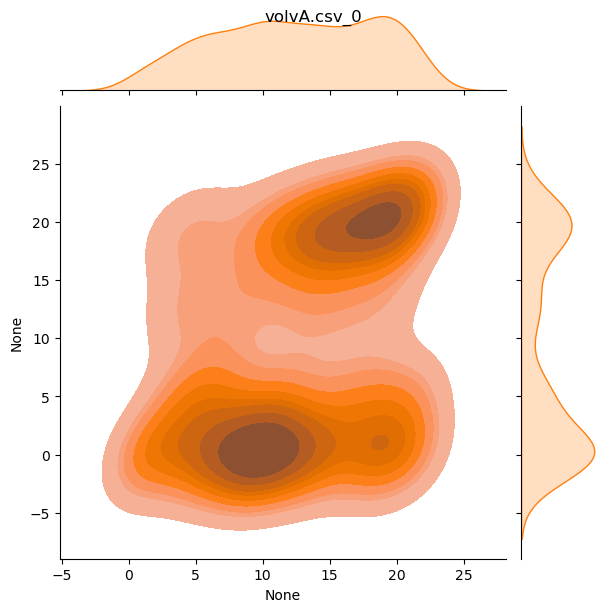

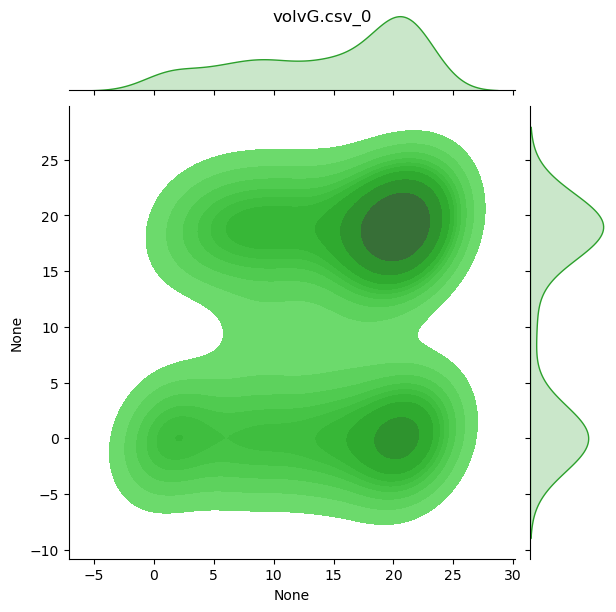

[[[1.33236787e+00 8.80073736e+00 2.81349618e+00 4.59854295e+03
   5.02642800e+10 5.88235294e-02]
  [1.76661479e+00 1.25692215e+01 3.47262313e+00 2.00737370e+00
   2.47903320e+02 1.33333333e-01]]]


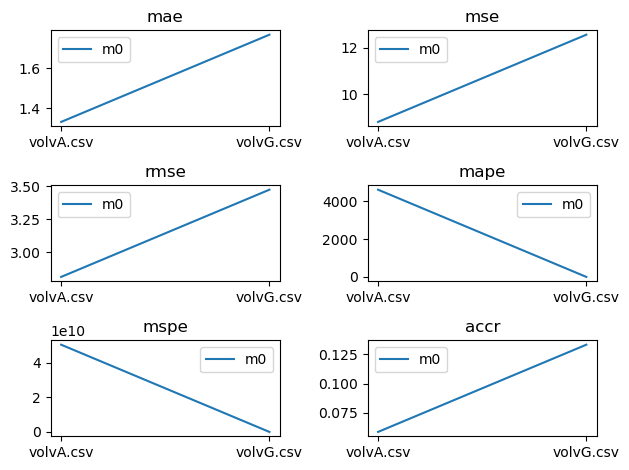

In [8]:
dep_var=['pmcat','close', 'hi', 'lo',]
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'prcs', True, data_path=[table], inverse=True))
  regplot(2)
  for j,result in enumerate(results):
    preds, trues, _ = result
    preds=preds[:,-22:].argmax(1)
    sns.jointplot(x=trues[:,0] , y=preds,kind="kde",fill=True,rug=True, color=f'C{j+1}')
    plt.suptitle(f'{tables[j]}_{i}')
  plt.show()

print(metrics)
plot_metric()  

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query="date>'#2024-04-30'", gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0vols/crossformer.pkl 
volvA.csv 14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14579    #2024-05-03 15:59:22#
Name: date, dtype: object
test 60
 mae:0.580, mse:0.913, rmse:0.944, mape:7933.807, mspe:21986394654.957, accr

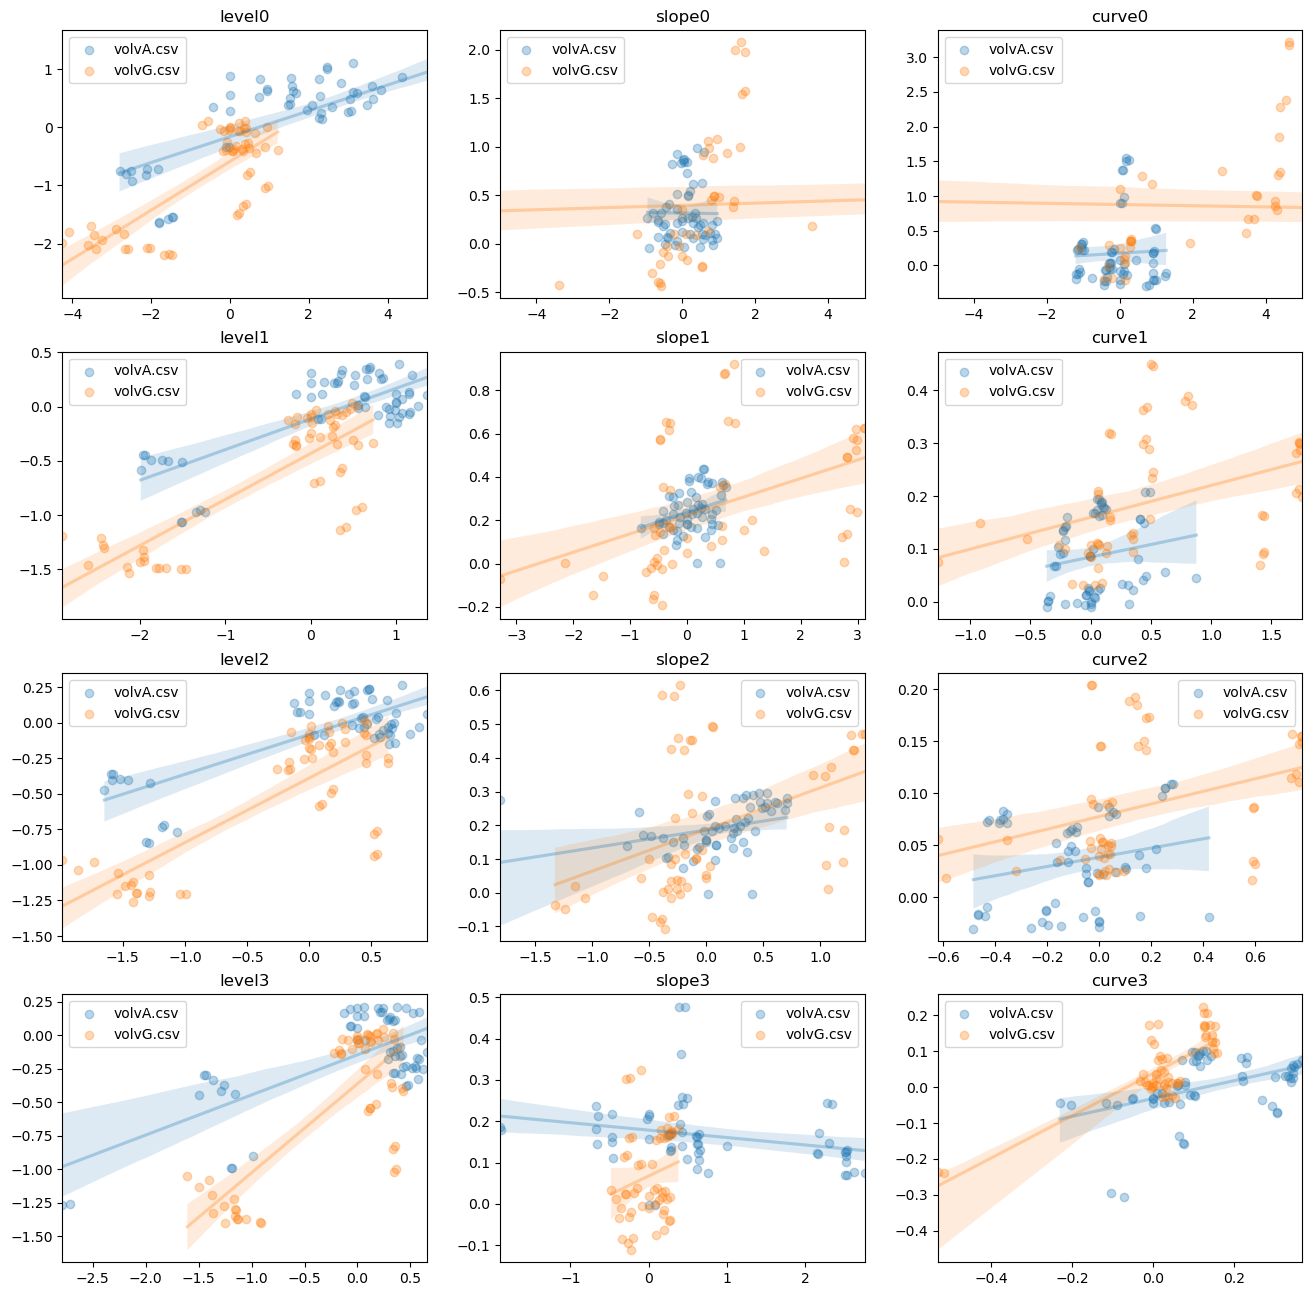

[[[ 5.79694194e-01  9.12991350e-01  9.43936556e-01  7.93380678e+03
    2.19863947e+10 -1.00000000e+00]
  [ 1.42959712e+00  1.82738765e+01  4.18682701e+00  3.65416631e+05
    3.07478151e+13 -1.00000000e+00]]]


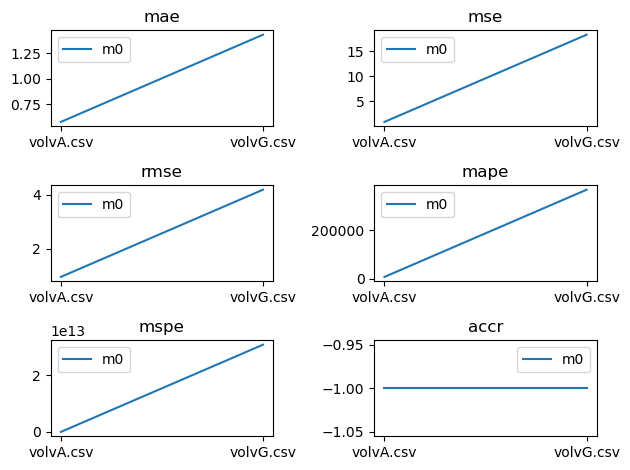

In [10]:
from data.data_loader import DatasetMTS
from cross_exp.exp_crossformer import Exp_crossformer
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        "query": f"date>'#{cutdate}'",
    },
    }

dep_var=['level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(3)

print(metrics)
plot_metric()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query="date>'#2024-04-30'", gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0vols/crossformer.pkl 
volvA.csv 14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14579    #2024-05-03 15:59:22#
Name: date, dtype: object
test 60
 mae:0.580, mse:0.913, rmse:0.944, mape:7933.807, mspe:21986394654.957, accr

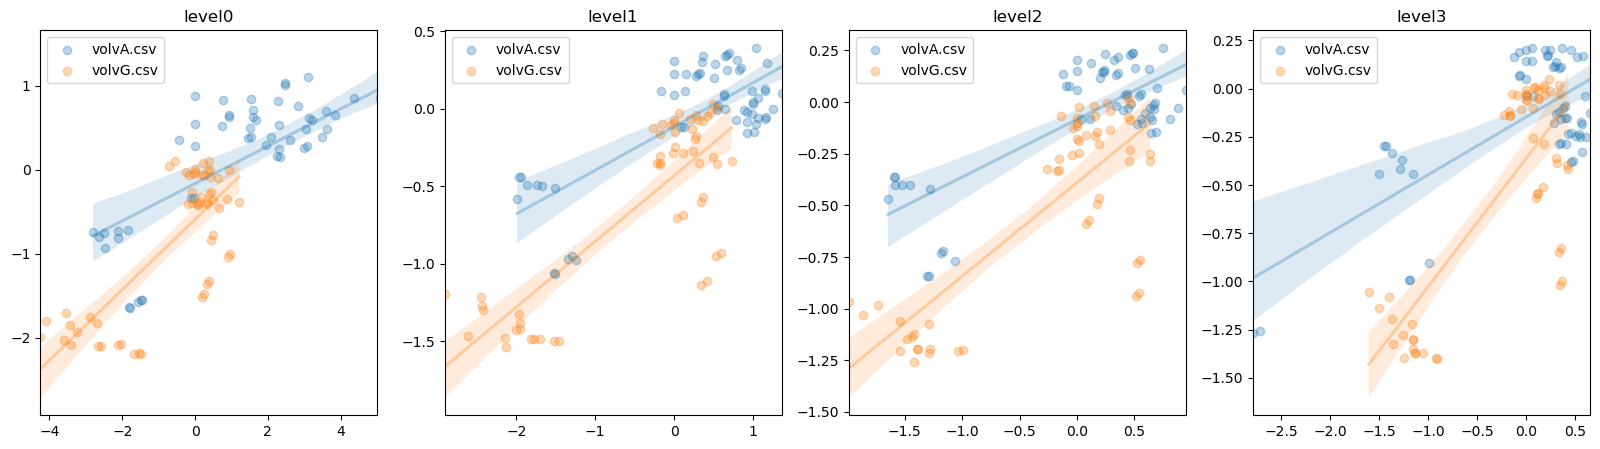

In [11]:
dep_var=['level0', '_', '_', 'level1', '_', '_', 'level2', '_', '_', 'level3', '_', '_']
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  regplot(4,(20,5))

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv', 'volvG.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query="date>'#2024-04-30'", gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_itr0prcs/crossformer.pkl 
volvA.csv 14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14347    #2024-04-30 15:52:12#
14579    #2024-05-03 15:59:22#
Name: date, dtype: object
test 60
 mae:1.560, mse:12.000, rmse:3.410, mape:4.650, mspe:1076.987, accr:0.033333

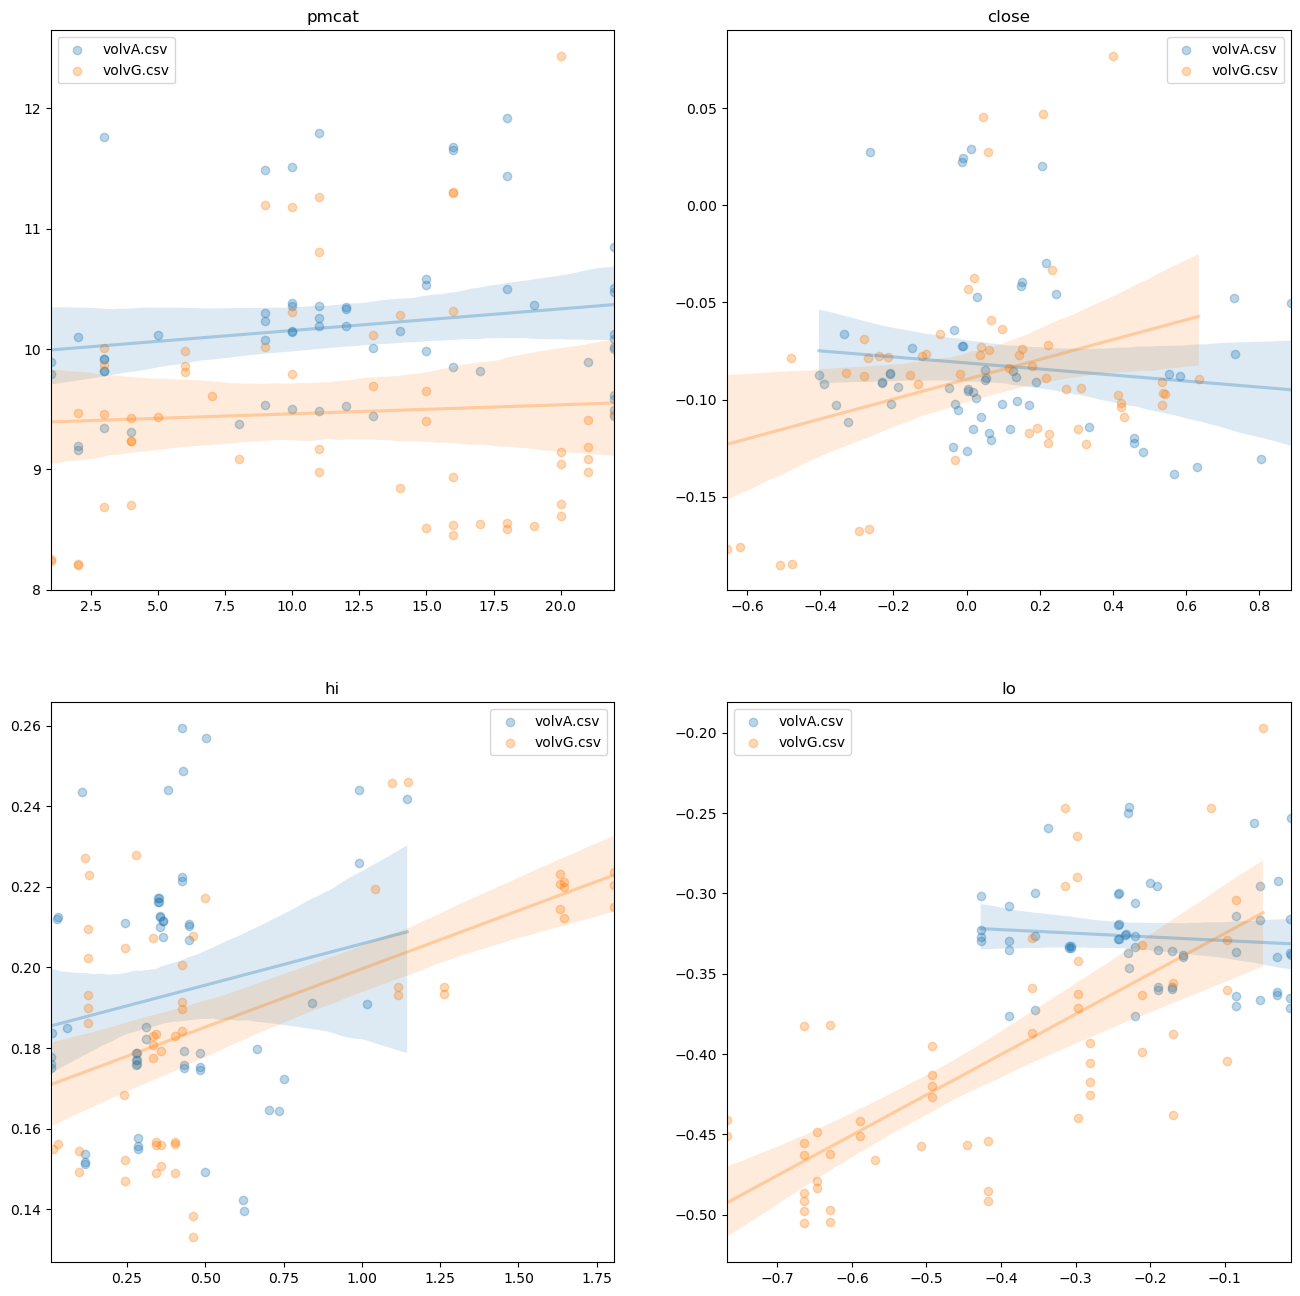

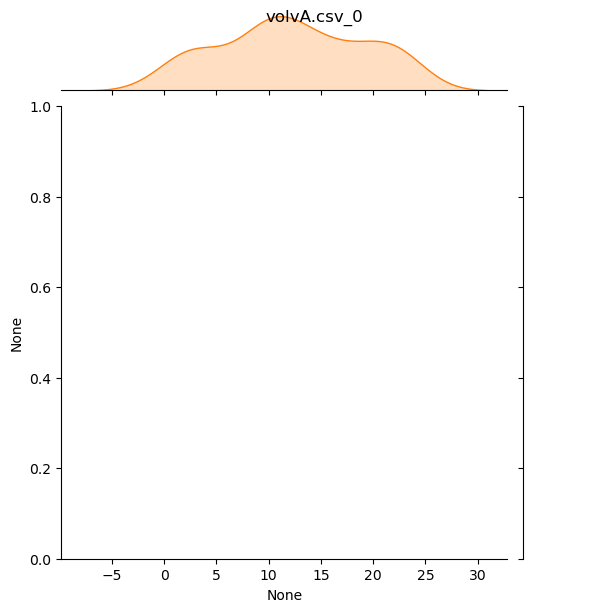

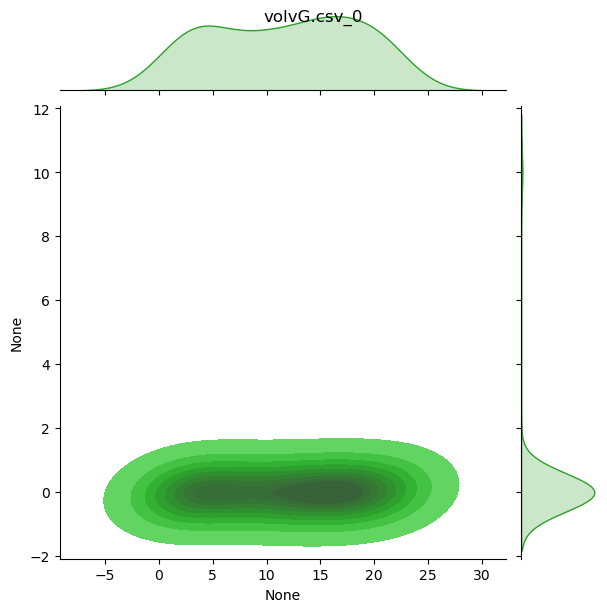

[[[1.55977736e+00 1.20003832e+01 3.40982736e+00 4.65002850e+00
   1.07698703e+03 3.33333333e-02]
  [1.71914167e+00 1.21293176e+01 3.34432310e+00 9.70669796e-01
   2.98463350e+00 3.63636364e-02]]]


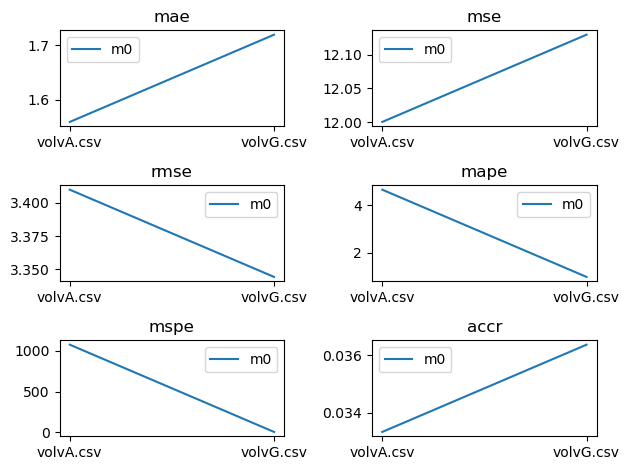

In [12]:
dep_var=['pmcat','close', 'hi', 'lo',]
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'prcs', True, data_path=[table], inverse=True))
  regplot(2)
  for j,result in enumerate(results):
    preds, trues, _ = result
    preds=preds[:,-22:].argmax(1)
    sns.jointplot(x=trues[:,0] , y=preds,kind="kde",fill=True,rug=True, color=f'C{j+1}')
    plt.suptitle(f'{tables[j]}_{i}')
  plt.show()
  
print(metrics)
plot_metric()  

In [ ]:
plt.show()
from google.colab import runtime
runtime.unassign()